In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import string
import numpy as np
#add google drive
import os
import re
# nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk import FreqDist
from functools import reduce
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer



# 1. LOAD DATASET + DEALING WITH MISSING VALUES 

In [3]:
#BUSINESS
# data path
business_json_path = '../data/yelp_academic_dataset_business.json'
#create new df
business_df = pd.DataFrame()

#read json file in a path
read_df_b = pd.read_json(business_json_path, lines=True, chunksize = 10000)

#storing each line of json into the new df to get a csv - runs in a few seconds
for i in read_df_b:

    business_df = i

    break

#info of df
#business_df.info()
#business_df.shape
#business_df
#CLEANED BUSINESS MISSING VALUES
business_df_copy = business_df.copy()
display(business_df_copy)

business_df_copy['categories'].isna().sum()
cats = business_df_copy['categories'].dropna().isna().sum()
#cats


#data path
review_json_path = '../data/yelp_academic_dataset_review.json'

#create new df
review_df = pd.DataFrame()

#read json file in a path
read_df_r = pd.read_json(review_json_path, lines=True, chunksize = 10000)

#storing each line of json into the new df to get a csv - runs in a few seconds
for i in read_df_r:
    review_df = i
    break

#info of df
display(review_df)
c= review_df.isna().sum()
b=business_df_copy.isna().sum()
print('business:',b)
print('review:',c)

review_df_copy = review_df.copy()


review_df_copy.info()
review_df.shape



,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Pdin4DKMYBbXLXanNDNwLQ,Knuckle Dusters Vapor,"1100 E Plumb Ln, Ste B",Reno,NV,89502,39.505271,-119.785091,5.0,45,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Tobacco Shops, Shopping, Vape Shops","{'Monday': '0:0-0:0', 'Tuesday': '10:0-20:0', ..."
9996,N-4ZOrM_qAnzBiCsJ7-ENA,Ricky's All Day Grill,140 Street Albert Road,St Albert,AB,T8N 7C8,53.620257,-113.611680,3.0,16,1,"{'RestaurantsAttire': 'u'casual'', 'BikeParkin...","Canadian (New), American (New), Restaurants",None
9997,KqvaJX11rb4Hp70D8Dw4oQ,Admirals Club PHL Terminal F,8000 Essington Ave,Philadelphia,PA,19153,39.880694,-75.237370,4.0,10,1,"{'Alcohol': ''full_bar'', 'HappyHour': 'False'...","Bars, Nightlife, Airport Lounges","{'Monday': '5:0-21:30', 'Tuesday': '5:0-21:30'..."
9998,Yv6HUVu7fRMnt_NtGdVQBw,Las Palmas Mexican Restaurant,1905 Hayes St,Nashville,TN,37203,36.152919,-86.798455,3.5,158,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Mexican","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:30',..."


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
...,...,...,...,...,...,...,...,...,...
9995,ZcBtCA9jGhLfakf1jJ2BAg,yab1cq5yzrTHzoyz8LYqYQ,1-z7wd860Rii4kbEMCT8DA,5,0,0,0,Excellent food and service. The place is funct...,2018-06-26 17:41:31
9996,UIkEO-10J6Y99IhRqUflvg,lYAmgL_l7A3MPFYe1DYKrw,EpREWeEpmR8f1qLHzzF0AA,5,0,1,0,Just about to get tucked into a meatloaf that ...,2018-01-09 20:26:13
9997,S-NQM3Axcg8JS3MXHUIvyw,rE2WwfgJbYfvDwBlgq__dQ,dvidzWEPgTQPeBc8CUV2OQ,5,0,0,0,Outstanding customer service! And my car is dr...,2015-04-01 21:50:28
9998,ME79YrEhm2xe4IQy_0zkGw,OnIklvzKDpk1BduC84TrTA,2XYPFRm7teCUr3eGsB2-qw,5,0,0,0,I and my husband went here for Dinner one day ...,2015-06-08 19:32:26


business: business_id        0
name               0
address            0
city               0
state              0
postal_code        0
latitude           0
longitude          0
stars              0
review_count       0
is_open            0
attributes       860
categories         6
hours           1508
dtype: int64
review: review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   review_id    10000 non-null  object        
 1   user_id      10000 non-null  object        
 2   business_id  10000 non-null  object        
 3   stars        10000 non-null  int64         
 4   useful       10000 non-null  int64         
 5   funny        10000 non-null  int64         
 6   cool 

(10000, 9)

# 2. JOINED DATASET

In [20]:
#run for text analysis
business_df.isnull().sum()
business_df_copy2 = business_df.copy()
business_df_copy3 = business_df_copy2.iloc[:,0:13]

#business_df_copy.dropna(inplace=True)
#business_df_copy.isna().sum()
business_df_copy3.columns
business_df_copy3.dropna(inplace=True)
business_df_copy3.shape

#run for text analysis
#filtering just categories that are restaurants to work in my dataset
business_df_new=business_df_copy3[business_df_copy3['categories'].str.contains("Restaurants")]
#business_df_new.info()
#business_df_new.isnull().sum()
joined_df = pd.merge(business_df_new, review_df_copy,how='inner',on = 'business_id')
#joined_df.info()
#joined_df.isnull().sum()
joined_df

#print(user_df.shape)


#business_df_new.head()
#review_df_copy.head()
# string_text = []
# for word in review_text:
#     string_text.append(word)
#
# string_text =' '.join(string_text).replace(" '", '')

#print(string_text)
#len(string_text) #2544374
null_joined_df =joined_df.isna().sum()
print('business:',null_joined_df)

#MAKE SURE TO EXPLAIN THE PROCESS THE DATA TO DO NOT GET MISSING VALUES 
print(business_df_new.shape)
print('Joined_df size:',joined_df.shape)

joined_df.to_csv('joined_df_review.csv', index = False)
joined_df

business: business_id     0
name            0
address         0
city            0
state           0
postal_code     0
latitude        0
longitude       0
stars_x         0
review_count    0
is_open         0
attributes      0
categories      0
review_id       0
user_id         0
stars_y         0
useful          0
funny           0
cool            0
text            0
date            0
dtype: int64
(3431, 13)
Joined_df size: (4845, 21)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,attributes,categories,review_id,user_id,stars_y,useful,funny,cool,text,date
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...",BXQcBN0iAi1lAUxibGLFzA,6_SpY41LIHZuIaiDs5FMKA,4,0,0,1,This is nice little Chinese bakery in the hear...,2014-05-26 01:09:53
1,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,...,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","Food, Delis, Italian, Bakeries, Restaurants",oTTuahWNWzX_018P6O6_2g,z1Dfj8kz3KCArkXaIyaBIA,1,6,1,0,The worst Chicken Parm. Sandwich I've ever eat...,2014-05-25 21:52:30
2,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,...,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","Food, Delis, Italian, Bakeries, Restaurants",R7DC4sHDcklrk1s1K93FDA,HvgKiuV36e9SzNqeA5zOfA,4,0,0,0,"Zio's, previously known as Cesarina's is a lar...",2018-07-26 16:25:04
3,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,...,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese",XYaDbPKyJAu4k2aUOIth5g,Qsk0aTclam9W_DIK6bx42A,5,0,0,0,Stopped in to check out this new spot around t...,2017-12-16 00:13:06
4,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,...,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese",tpLolBuBTx_Ncx3RSf7WBw,TJW1aEzjhaxbD10fjhokfQ,1,0,0,0,I live in the neighborhood and used to order a...,2018-04-28 00:46:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4840,Yv6HUVu7fRMnt_NtGdVQBw,Las Palmas Mexican Restaurant,1905 Hayes St,Nashville,TN,37203,36.152919,-86.798455,3.5,158,...,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Mexican",p0hyF98o6SSbCTtTcYRXBQ,ipNdkt9x5UEs7YeH9l61sA,1,3,0,0,"AWFUL. I have been there more than once, and i...",2017-12-16 03:13:19
4841,Yv6HUVu7fRMnt_NtGdVQBw,Las Palmas Mexican Restaurant,1905 Hayes St,Nashville,TN,37203,36.152919,-86.798455,3.5,158,...,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Mexican",0uD1hdeUNPyfAaGOKpMMeQ,DWGywipRRede0hIpZ4tDag,5,0,0,0,This is one of our favorite spots in Nashville...,2018-06-19 18:16:51
4842,Yv6HUVu7fRMnt_NtGdVQBw,Las Palmas Mexican Restaurant,1905 Hayes St,Nashville,TN,37203,36.152919,-86.798455,3.5,158,...,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Mexican",dZekZLTdAvIYD4lQnMLIjw,PIVuLifCMnRpwiEFpIQLdg,4,1,0,1,"Hello again yelpers!\n\nI gotta say, this is a...",2016-10-13 21:05:52
4843,Yv6HUVu7fRMnt_NtGdVQBw,Las Palmas Mexican Restaurant,1905 Hayes St,Nashville,TN,37203,36.152919,-86.798455,3.5,158,...,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Mexican",oG4T41u57GeTqlt_yGDmrg,_R40mCFgPGWXNrlLvXZhsQ,5,0,0,0,Always good food! The grilled fish is one of o...,2018-03-23 15:07:40


# 3. TEXT PROCESSING

In [5]:
table = str.maketrans('', '', string.punctuation)#in place of punctuation replaces with space or removes it
def text_process(mess):
    words = re.split(r'\W+', mess)
    nopunc = [w.translate(table) for w in words]

    nostop =  ' '.join([word for word in nopunc if word.lower() not in stopwords.words('english')])
    return nostop


In [6]:
joined_df['text'] = joined_df['text'].apply(lambda text:text_process(text))
joined_df['text']

0       nice little Chinese bakery heart Philadelphia ...
1       worst Chicken Parm Sandwich ever eaten chicken...
2       Zio previously known Cesarina largo staple lit...
3       Stopped check new spot around corner us boyfri...
4       live neighborhood used order least week pick l...
                              ...                        
4840    AWFUL never great ok However recent time went ...
4841    one favorite spots Nashville recently remodele...
4842    Hello yelpers gotta say pretty solid mexican r...
4843    Always good food grilled fish one favorites Pr...
4844    Went late dinner probably 7 15 first time Las ...
Name: text, Length: 4845, dtype: object

In [7]:
#reference this code [https://gaurav5430.medium.com/using-nltk-for-lemmatizing-sentences-c1bfff963258]
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [8]:
joined_df['text'] = joined_df['text'].apply(lambda text:lemmatize_sentence(text))
joined_df['text']

0       nice little Chinese bakery heart Philadelphia ...
1       worst Chicken Parm Sandwich ever eaten chicken...
2       Zio previously know Cesarina largo staple litt...
3       Stopped check new spot around corner us boyfri...
4       live neighborhood use order least week pick la...
                              ...                        
4840    AWFUL never great ok However recent time go WO...
4841    one favorite spot Nashville recently remodel l...
4842    Hello yelpers get ta say pretty solid mexican ...
4843    Always good food grill fish one favorites Pric...
4844    Went late dinner probably 7 15 first time Las ...
Name: text, Length: 4845, dtype: object

In [9]:
def tokenize(token):    
    word_tokens  = nltk.word_tokenize(token)
    return word_tokens

In [10]:
#if I do that It will edit the main joined_df['text] column 
joined_df['text'] = joined_df['text'].apply(lambda text:tokenize(text))
joined_df['text']

0       [nice, little, Chinese, bakery, heart, Philade...
1       [worst, Chicken, Parm, Sandwich, ever, eaten, ...
2       [Zio, previously, know, Cesarina, largo, stapl...
3       [Stopped, check, new, spot, around, corner, us...
4       [live, neighborhood, use, order, least, week, ...
                              ...                        
4840    [AWFUL, never, great, ok, However, recent, tim...
4841    [one, favorite, spot, Nashville, recently, rem...
4842    [Hello, yelpers, get, ta, say, pretty, solid, ...
4843    [Always, good, food, grill, fish, one, favorit...
4844    [Went, late, dinner, probably, 7, 15, first, t...
Name: text, Length: 4845, dtype: object

In [11]:
def word_freq(columnName):
    freq = Counter([item for sublist in columnName.to_list() for item in sublist])
    return freq

In [12]:
#calling frequency 
print_word_freq=word_freq(joined_df['text'])
#rint(print_word_freq)
#{'food': 3119, 'good': 2990, 'place': 2803, 'get': 2425, 'go': 2183, 'order': 2067, 'great': 1849, 'time': 1735, 'come': 1556, 'like': 1545, 'service': 1451, 'make': 1318, 'back': 1291, 'one': 1254, 'try': 1164, 'restaurant': 1147, 'would': 1144, 'really': 1038, 'well': 1035, 'say': 920, 'take': 912, 'us': 907, 'wait': 894, 'menu': 887, 'delicious': 832, 'love': 814, 'chicken': 806, 'eat': 806, 'also': 803, 'best': 784, 'table': 766, 'nice': 757, 'little': 735, 'want': 709, 'fry': 699, 'look': 692, 'even': 685, 'price': 679, 'taste': 668, 'friendly': 666, 'drink': 650, 'give': 645, 'meal': 642, 'sauce': 641, 'bar': 639, 'staff': 622, 'always': 612, 'think': 612, 'fresh': 610, 'pizza': 597, 'experience': 571, 'know': 568, 'could': 560, 'cheese': 556, 'pretty': 554, 'lunch': 545, 'dish': 541, 'night': 538, 'ask': 529, 'definitely': 524, 'recommend': 522, 'salad': 522, 'much': 511, 'flavor': 505, 'people': 500, 'serve': 499, 'sandwich': 497, 'burger': 495, 'minute': 491, 'beer': 489, 'first': 484, 'Great': 483, '2': 475, 'never': 472, 'star': 472, 'way': 468, 'thing': 467, 'side': 467, 'dinner': 465, 'ever': 462, 'day': 460, 'find': 460, 'friend': 455, 'area': 443, 'server': 440, 'bad': 435, '5': 433, 'two': 432, 'right': 431, 'seat': 427, 'around': 426, 'visit': 423, 'small': 421, 'enjoy': 416, '3': 401, 'hour': 400, 'amaze': 391, 'review': 391, 'tell': 388, 'sure': 385, 



In [13]:
#now we will re-join the now clean list of tokens into a single text and generate the cloud.
joined_df_copy = joined_df['text'].copy()
rejoined_text = [word for word in joined_df_copy ]


In [14]:
#building wordcloud to see the most common words and then compare to LDA topics


def wordcloud_yelp(columName2):
    wordcloud = WordCloud(width = 1000, height = 700,
                          background_color ='black', colormap=plt.cm.autumn,
                          min_font_size = 10).generate(str(columName2))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

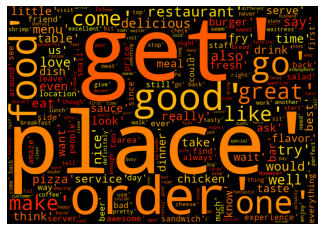

In [15]:
#wordclod from tokens tranformed into string, we can observe some words aren't as accurate so more analysis is necessary 
print_wordfreq=wordcloud_yelp(rejoined_text )


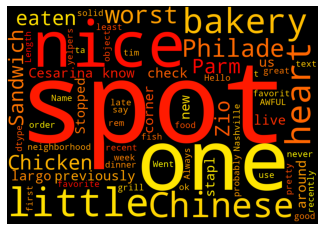

In [16]:
#wordclod from tokens without tranformed into string, we can observe some words aren't appearing based on freqeuncy which indicates that possibly the words showing in teh cloud are teh first column of each row. 
print_wordfreq=wordcloud_yelp(joined_df['text'])

In [17]:
#change variable names here
#inspired by: https://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/
from sklearn.feature_extraction.text import TfidfVectorizer

def dummy_fun(doc):
    return doc
#TFidf
tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)

In [18]:
#REFERENCE: https://levelup.gitconnected.com/natural-language-processing-and-topic-modeling-on-user-review-dataset-66599beaa50e
#tf-idf TRNAFORMATION
tfidf_model = TfidfVectorizer(
    max_df=0.99, # max_df : maximum document frequency for the given word
    max_features=1000, # max_features: maximum number of words
    min_df=0.01, # min_df : minimum document frequency for the given word
    use_idf=True, # use_idf: if not true, we only calculate tf
    tokenizer=joined_df['text'],
    ngram_range=(1,1) # ngram_range: (min, max), eg. (1, 2) including 1-gram, 2-gram
)


#fit the TfidfVectorizer to our data
tfidf_matrix = tfidf_model.fit_transform(joined_df)


print("In total, there are {} reviews and {} terms.".format(
    str(tfidf_matrix.shape[0]), str(tfidf_matrix.shape[1])
))

TypeError: 'Series' object is not callable

In [ ]:
tf_matrix_lda = tfidf.fit_transform(joined_df['text'])

tf_matrix_lda_copy = tf_matrix_lda.copy()

In [ ]:
tf_matrix_lda_copy.toarray()

In [ ]:

#how to split data for my model and split training set and test set(validation to tune and to know if it is good or bad model). 
#big data - 80/20
#small dsata - 90/10
# Use LDA for clustering
LDA = LatentDirichletAllocation(n_components=10)

# document topic matrix for tf_matrix_lda
lda_output = LDA.fit_transform(tf_matrix_lda)

In [ ]:
print(lda_output)

In [ ]:
#this is not working properly
#print(tf_matrix_lda.shape) #(4845, 21159)
#In total, there are 4845 reviews and 21159 terms.

# feature names
lda_feature_names = LDA.get_feature_names()



In [ ]:
#new way of trying to Prepare text for LDS 
#we are using the bag of words to prpare the data for LDA 
#from https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0 
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(joined_df['text'])

# Create Corpus
texts = joined_df['text']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

In [ ]:
print(joined_df['text'])
type(joined_df['text'])

In [ ]:
#Step 5: LDA model tranining 
import gensim
from pprint import pprint
from gensim import models
#from gensim.models.wrappers import LdaMallet

# number of topics
num_topics = 7
#num_topics = 10 #too many topics and very similar between each other, the bubbles overlap
#num_topics = 3 #too less topics and very similar between each other even if the bubbles are very far from each other. 
#num_topics = 5 #numb of topics is okay, still bubbble 1,2,3 are very similar between each other and they overlap. But 4 and 5, are good and separeted still they have similarities. 
#num_topics = 7.5 #numb of topics is okay, still bubbble 1,2,3 and 5 are very similar between each other and they overlap. Also topic 7 seems reduces the red bars a lot, and 6 as well. 
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
#!pip install pyLDAvis - in case it doesn't work
#Step 6: Analyzing our LDA model
import pyLDAvis
#import pyLDAvis.gensim
import pyLDAvis.gensim_models
import pickle
pyLDAvis.enable_notebook()

In [ ]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis
#worth checking on the data pre-processing lemmatizacion - checking different version from teh words 
#1. max number of words in vocab
#2. make sure 
#chi2 fo feature selection - have a look on those. 
#n-grams and tehn feature selection. - THIS IS FOR IMPROVEMENT
#revise bag of words - to make sure that we get all topic labels 


In [ ]:
#worth checking on the data pre-processing lemmatizacion - checking different version from teh words 
#1. max number of words in vocab
#2. make sure 
#3. Text blog for pre-processing 
#chi2 fo feature selection - have a look on those. 
#n-grams and tehn feature selection. - THIS IS FOR IMPROVEMENT
#revise bag of words - to make sure that we get all topic labels 

#In our case, for classifctaion text, visualization techniques py library, TSNE: cosine similarity as a measure because eof the spar type of data, confusion matrix, cross validation. 


In [ ]:
from sklearn.manifold import TSNE #it doesn't work
tsne_model = TSNE(n_components=2, verbose=1, random_state=7, angle=.99, init="random")
# 13-D -> 2-D
tsne_lda = tsne_model.fit_transform(tf_matrix_lda_copy ) # doc_topic is document-topic matrix from LDA or GuidedLDA  
#insipred by: https://towardsdatascience.com/visualizing-topic-models-with-scatterpies-and-t-sne-f21f228f7b02

In [ ]:
#try to evaluate choerence of teh model
from gensim.models import CoherenceModel

lda_model_coherence = CoherenceModel(model=lda_model,texts=joined_df['text'],dictionary=id2word,coherence='c_v')
coherence_lda = lda_model_coherence.get_coherence()
print(coherence_lda)

In [ ]:
lda_model[corpus[0]]

In [ ]:
len(corpus)

In [ ]:
hm = np.array([[y for (x,y) in lda_model[corpus[i]]] for i in range(len(corpus))])

In [ ]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=7, angle=.99, init="random")
# 13-D -> 2-D
tsne_lda = tsne_model.fit_transform(tf_matrix_lda_copy ) # doc_topic is document-topic matrix from LDA or GuidedLDA
embedding = pd.DataFrame(embedding, columns=['x','y'])
embedding['hue'] = hm.argmax(axis=1)